In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 2.2MB/s ta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                    

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [18]:
# The code was removed by Watson Studio for sharing.

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [7]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data

In [9]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

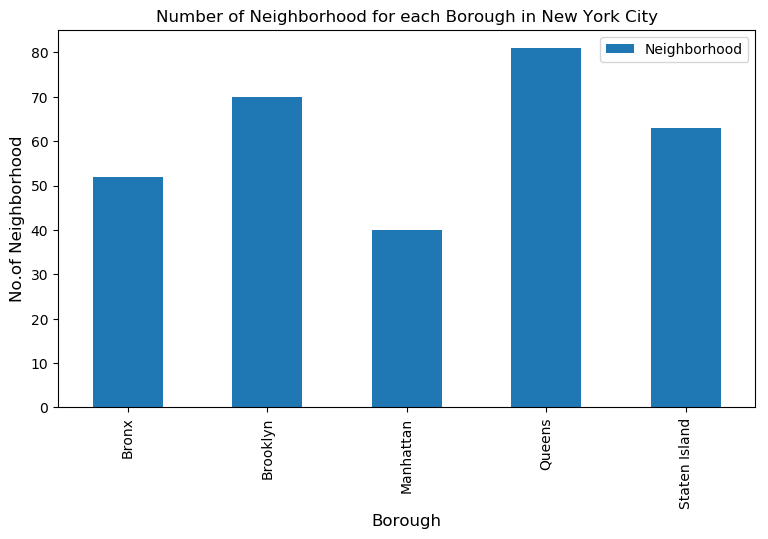

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will collect Chinese resturants for each Neighborhood

In [12]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
    
chinese_rest_ny.head()

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:1
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:0
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Chinese Resturants in City Island, Bronx:0
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:3
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:3
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Bronx,Kingsbridge,4ec2fa2f0aaf300b7fb29e5a,Golden Gate Express
3,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant


In [13]:
chinese_rest_ny.shape

(220, 4)

We got 220 Chinese Resturants across New York City.Let's see Chinese restaurants in each borough.

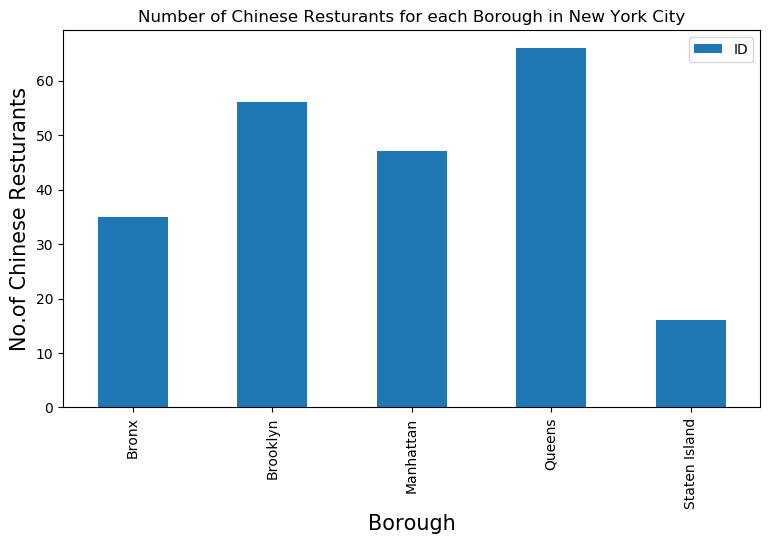

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Lets See Chinese restaurants in each neighborhood.

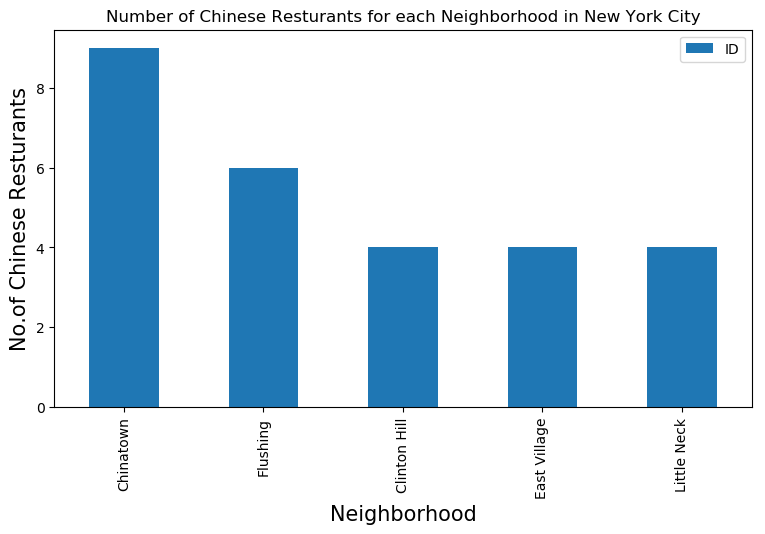

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
70,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
71,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
72,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
73,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
74,Manhattan,Chinatown,3fd66200f964a52067e61ee3,Joe's Shanghai 鹿嗚春
75,Manhattan,Chinatown,4afff2b4f964a520583a22e3,Sun Hing Lung Ho Fun Tofu
76,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
77,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
78,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺


So Chinatown in Manhattan has the highest number of Chinese Resturants with a total count of 9. We will get the ranking of each resturant for further analysis.

In [19]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        print(ID)
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

4c9d5f2654c8a1cd2e71834b
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 1 / 220 ) processed
4dabc3dc93a04642f09ccabd
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 2 / 220 ) processed
4ec2fa2f0aaf300b7fb29e5a
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ec2fa2f0aaf300b7fb29e5a
( 3 / 220 ) processed
4e41d2c4b61ca5ba3b1f9c6b
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
( 4 / 220 ) processed
4b9d6b45f964a52078ab36e3
                         ID                        Name  Likes  Rating  Tips
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant      9     7.5    10
( 5 / 220 ) processed
4e2e08021838f1c552b6b8eb
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yu

In [20]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0,0
1,Bronx,Eastchester,0,0,0,0,0
2,Bronx,Kingsbridge,0,0,0,0,0
3,Bronx,Norwood,0,0,0,0,0
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.5,10


In [21]:
chinese_rest_stats_ny.shape

(220, 7)

In [22]:
chinese_rest_ny.shape

(220, 4)

lets save this data to a csv sheet. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [23]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

In [24]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [25]:
chinese_rest_stats_ny_csv.shape

(220, 7)

In [47]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0.0,0
1,Bronx,Eastchester,0,0,0,0.0,0
2,Bronx,Kingsbridge,0,0,0,0.0,0
3,Bronx,Norwood,0,0,0,0.0,0
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.5,10


Data verified from CSV file

In [26]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 7 columns):
Borough         220 non-null object
Neighborhood    220 non-null object
ID              220 non-null object
Name            220 non-null object
Likes           220 non-null object
Rating          220 non-null object
Tips            220 non-null object
dtypes: object(7)
memory usage: 12.1+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [27]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')

In [28]:
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')

In [29]:
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [30]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 7 columns):
Borough         220 non-null object
Neighborhood    220 non-null object
ID              220 non-null object
Name            220 non-null object
Likes           220 non-null float64
Rating          220 non-null float64
Tips            220 non-null float64
dtypes: float64(3), object(4)
memory usage: 12.1+ KB


In [31]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1453
Rating                               9.2
Tips                                 508
Name: 97, dtype: object

In [32]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1453
Rating                               9.2
Tips                                 508
Name: 97, dtype: object

In [33]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              3fd66200f964a52067e61ee3
Name                  Joe's Shanghai 鹿嗚春
Likes                               1288
Rating                               8.5
Tips                                 568
Name: 74, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [34]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [35]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
51,Flatiron,9.200000
22,Chelsea,9.200000
135,Windsor Terrace,9.100000
134,West Village,8.950000
128,Upper West Side,8.900000
85,Midtown,8.800000
74,Little Italy,8.800000
42,East Village,8.700000
39,Downtown,8.700000
61,Greenwich Village,8.633333


Above are the top neighborhoods with top average rating of Chinese resturants

In [36]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [100]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.940426
3,Queens,4.215152
1,Brooklyn,4.091071
4,Staten Island,2.150000
0,Bronx,1.931429


Lets visualize it

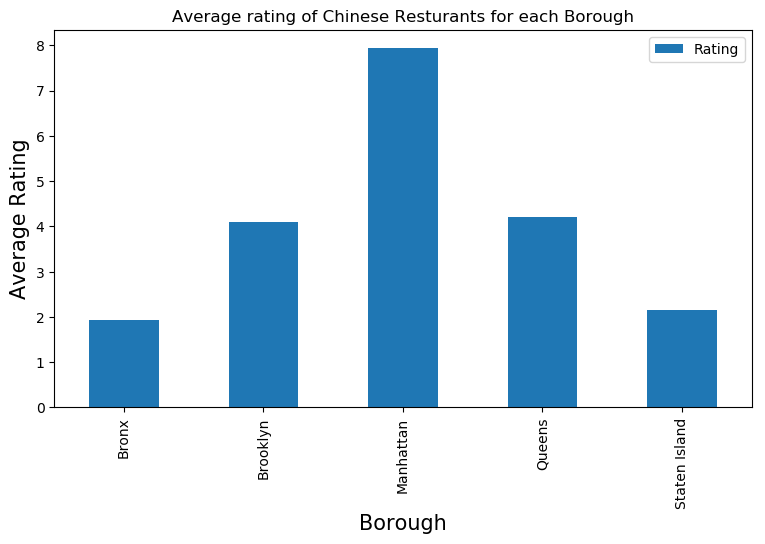

In [37]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.7 to visualize on map

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.7]

In [39]:
ny_neighborhood_stats

,Neighborhood,Average Rating
22,Chelsea,9.20
39,Downtown,8.70
42,East Village,8.70
51,Flatiron,9.20
74,Little Italy,8.80
85,Midtown,8.80
128,Upper West Side,8.90
134,West Village,8.95
135,Windsor Terrace,9.10


In [40]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [42]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.20
1,Staten Island,Chelsea,40.594726,-74.189560,9.20
2,Brooklyn,Downtown,40.690844,-73.983463,8.70
3,Manhattan,East Village,40.727847,-73.982226,8.70
4,Manhattan,Flatiron,40.739673,-73.990947,9.20
5,Manhattan,Little Italy,40.719324,-73.997305,8.80
6,Manhattan,Midtown,40.754691,-73.981669,8.80
7,Manhattan,Upper West Side,40.787658,-73.977059,8.90
8,Manhattan,West Village,40.734434,-74.006180,8.95
9,Brooklyn,Windsor Terrace,40.656946,-73.980073,9.10


Now we will show this data on a map

In [43]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [56]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [57]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Map file is added as https://github.com/dsinghra123/DataScienceCapstone/blob/master/Untitled.png